# LangGraph Examples
This notebook contains examples related to Langgraph Echosystems

## Setup LLM
First things first, we need to setup LLM instance which will be used throughout this project

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
import dotenv
import os

# Import GOOGLE_API_KEY to use gemini model
# https://console.cloud.google.com/apis/credentials
dotenv.load_dotenv()
if "GOOGLE_API_KEY" not in os.environ:
    raise ValueError("Please set the GOOGLE_API_KEY environment variable.")

# Create the LLM instance
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    temperature=0.1,
    max_output_tokens=1024,
)

In [2]:
# Invoke

llm.invoke("Who are you?").content

'I am a large language model, trained by Google.'

## LLM Augmentation
Adding tool calling and Structured Response ainto LLM in a seamless manner as LLM supports augmentations.

### Structured Response
Adding strucutred response into LLM so final output will be in the expected structure.

In [3]:
from pydantic import BaseModel, Field


class Restaurant(BaseModel):
    name: str = Field(description="The name of the restaurant")
    cuisine: str = Field(description="The type of cuisine the restaurant serves")
    rating: float = Field(description="The average rating of the restaurant")

llm_with_structured_output = llm.with_structured_output(Restaurant)

llm_with_structured_output.invoke(
    """I got list of indian restaurants as below, give me a restaurant which is above 4 ratings.
    restaurants: Spice of India = 4.5, Curry House = 4.0, Tandoori Nights = 3.0
    """
)

Restaurant(name='Spice of India', cuisine='Indian', rating=4.5)

### Adding tools
Tools will be added into LLM which can be invoked using LLM. Tools allow LLM to perform operations on external systems.

In [4]:
def get_restaurants(cuisine_type: str) -> dict[str, list[dict[str, str]]]:
    """
    Get a list of restaurants based on the cuisine type.
    """
    # Simulated data for demonstration purposes
    restaurants = {
        "Indian": [
            {
                "name": "Spice of India",
                "rating": 4.5,
            },
            {
                "name": "Curry House",
                "rating": 4.0,
            },
            {
                "name": "Tandoori Nights",
                "rating": 3.0,
            }
        ],
        "Italian": [
            {
                "name": "Pasta Palace",
                "rating": 4.7,
            },
            {
                "name": "Pizza Perfection",
                "rating": 3.0,
            }
        ]
    }
    return restaurants.get(cuisine_type, [])
    
llm_with_tools = llm.bind_tools([get_restaurants])
llm_with_tools.invoke("Suggest a good Italian restaurants.").tool_calls

[{'name': 'get_restaurants',
  'args': {'cuisine_type': 'Italian'},
  'id': '82ae6d77-fd1c-4ca8-a5c8-40f613eeb6e4',
  'type': 'tool_call'}]

We can implement toolcalling mechanism

In [5]:
for call in llm_with_tools.invoke("Suggest a good Italian restaurants.").tool_calls:
    if call.get("name") == "get_restaurants":
        print(f"Result of tool {call['name']}: {get_restaurants(call['args']['cuisine_type'])}")

Result of tool get_restaurants: [{'name': 'Pasta Palace', 'rating': 4.7}, {'name': 'Pizza Perfection', 'rating': 3.0}]


## Workflow
Workflow involves a series of steps or nodes, each responsible for a specific task. The output of one node can be used as the input for the next node, allowing for a seamless flow of information and context throughout the process.


In [6]:
# This data will be used throughout this project
data = {
  "Indian": [
    {
      "name": "Spice of India",
      "rating": 4.5,
      "menu": [
        { "item": "Butter Chicken", "ingredients": ["Chicken", "Butter", "Tomatoes", "Cream", "Spices"] },
        { "item": "Palak Paneer", "ingredients": ["Spinach", "Paneer", "Garlic", "Onion", "Spices", "Cashew"] },
        { "item": "Chicken Biryani", "ingredients": ["Basmati Rice", "Chicken", "Yogurt", "Mint", "Saffron"] },
        { "item": "Chana Masala", "ingredients": ["Chickpeas", "Tomatoes", "Onion", "Cumin", "Coriander"] },
        { "item": "Garlic Naan", "ingredients": ["Flour", "Yeast", "Garlic", "Butter", "Salt"] }
      ]
    },
    {
      "name": "Tandoori Nights",
      "rating": 3.0,
      "menu": [
        { "item": "Tandoori Chicken", "ingredients": ["Chicken", "Yogurt", "Ginger", "Garlic", "Spices"] },
        { "item": "Paneer Tikka", "ingredients": ["Paneer", "Bell Peppers", "Onion", "Yogurt", "Spices"] },
        { "item": "Seekh Kebab", "ingredients": ["Minced Lamb", "Onion", "Garlic", "Mint", "Spices"] },
        { "item": "Dal Tadka", "ingredients": ["Lentils", "Onion", "Tomato", "Garlic", "Cumin"] },
        { "item": "Roti", "ingredients": ["Wheat Flour", "Water", "Salt", "Oil", "Butter"] }
      ]
    }
  ],
  "Italian": [
    {
      "name": "Pasta Palace",
      "rating": 4.7,
      "menu": [
        { "dish_name": "Spaghetti Carbonara", "ingredients": ["Spaghetti", "Eggs", "Parmesan", "Pancetta", "Black Pepper"] },
        { "dish_name": "Lasagna", "ingredients": ["Pasta Sheets", "Ricotta", "Ground Beef", "Tomato Sauce", "Mozzarella"] },
        { "dish_name": "Penne Arrabbiata", "ingredients": ["Penne", "Tomatoes", "Chili", "Garlic", "Olive Oil"] },
        { "dish_name": "Fettuccine Alfredo", "ingredients": ["Fettuccine", "Butter", "Parmesan", "Cream", "Garlic"] },
        { "dish_name": "Minestrone Soup", "ingredients": ["Vegetables", "Beans", "Pasta", "Tomatoes", "Herbs"] }
      ]
    },
    {
      "name": "Pizza Perfection",
      "rating": 3.0,
      "menu": [
        { "dish_name": "Margherita Pizza", "ingredients": ["Pizza Dough", "Tomato Sauce", "Mozzarella", "Basil", "Olive Oil"] },
        { "dish_name": "Pepperoni Pizza", "ingredients": ["Pizza Dough", "Tomato Sauce", "Mozzarella", "Pepperoni", "Oregano"] },
        { "dish_name": "Quattro Formaggi", "ingredients": ["Pizza Dough", "Mozzarella", "Gorgonzola", "Parmesan", "Ricotta"] },
        { "dish_name": "Vegetarian Pizza", "ingredients": ["Pizza Dough", "Tomato Sauce", "Mushrooms", "Bell Peppers", "Olives"] },
        { "dish_name": "Calzone", "ingredients": ["Pizza Dough", "Mozzarella", "Ham", "Mushrooms", "Tomato Sauce"] }
      ]
    }
  ]
}

State can store data which can be passed between prompts. This is useful for maintaining context and keeping track of user preferences or previous interactions.
In python we use typing_extensions to define the state structure.

In [7]:
from typing_extensions import TypedDict

class State(TypedDict):
    cuisine: str
    dish_type: str
    dish_name: str

Create a node for selecting a dish

In [8]:
def select_dish(state: State) -> str:
    msg = llm.invoke(f"Give me dish name only, no any other text or information. Select a {state['dish_type']} from {state['cuisine']} cuisine. Use this data: {data}")
    return {"dish_name": msg.content.strip()}

Create workflow

```mermaid
graph LR;
    A(Start) ---> B[Select Dish];
    B ---> C(End);
    D[[STATE]] -.-> A
    D -.-> B
    D -.-> C
```

In [9]:
from langgraph.graph import StateGraph, START, END
workflow = StateGraph(State)

# Add Nodes
workflow.add_node("select dish", select_dish)

# Connect Nodes 
workflow.add_edge(START, "select dish")
workflow.add_edge("select dish", END)

# Compile and create chain
chain = workflow.compile()

# Invoke with initial data for the state
initial_state = {"cuisine": "Italian", "dish_type": "Pasta"}
chain.invoke(initial_state)


{'cuisine': 'Italian',
 'dish_type': 'Pasta',
 'dish_name': 'Spaghetti Carbonara'}

Visualizing above Workflow

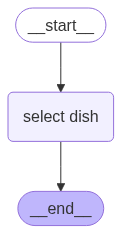

In [10]:
from IPython.display import Image, display
display(Image(chain.get_graph().draw_mermaid_png()))

### Complex Workflow Patterns
In real world we chain multiple prompts together to create a more complex workflow interaction. For example, we might first ask for a list of restaurants, and then ask for more details about a specific restaurant from that list.


#### Linear Workflow:

```mermaid
graph LR;
    A[User Input] --> B[Restaurant Selection];
    B --> C[Dish Selection];
    C --> D[Get Dish ingredients Details];
    D --> E[Check Allergens];
```

Create state which includes all necessary information for the workflow and used by each node function.

In [11]:
from typing_extensions import TypedDict

class State(TypedDict):
    cuisine: str
    name: str
    dish_type: str
    dish_name: str
    ingredients: list[str]
    allergens: list[str]


Create Nodes for above chain

In [12]:
def select_restaurant(state: State) -> str:
    msg = llm.invoke(
        f"Give only name, no any other text or informations. Select a {state['cuisine']} restaurant with rating above 4.0 from given data: {data}",
        state
    )
    return {"name": msg.content}  # Simulated response for demonstration

def select_dish(state: State) -> str:
    msg = llm.invoke(
        f"Give dish name only, no any other text or informations. Select a dish from {state['name']} restaurant which is {state['dish_type']} type from given data: {data}",
        state
    )
    return {"dish_name": msg.content}  # Simulated response for demonstration

def get_dish_ingredients(state: State) -> list[str]:
    msg = llm.invoke(
        f"Give only ingredient names, no any other text or informations. Names should be comma separated. Get ingredients for {state['dish_name']} from {state['name']} restaurant: {data}",
        state
    )
    return {"ingredients": msg.content.split(", ")}  # Simulated response for demonstration

def check_allergens(state: State) -> list[str]:
    msg = llm.invoke(
        f"Give only allergen names, no any other text or informations. Names should be comma separated. If no allergens, say 'No allergens found'. Check allergens for {state['dish_name']} from {state['name']} restaurant: {data}",
        state
    )
    return {"allergens": msg.content.split(", ")}  # Simulated response for demonstration


Create Workflow by connecting nodes and invoke it with initial state

In [13]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)
workflow.add_node("select_restaurant", select_restaurant)
workflow.add_node("select_dish", select_dish)
workflow.add_node("get_dish_ingredients", get_dish_ingredients)
workflow.add_node("check_allergens", check_allergens)

workflow.add_edge(START, "select_restaurant")
workflow.add_edge("select_restaurant", "select_dish")
workflow.add_edge("select_dish", "get_dish_ingredients")
workflow.add_edge("get_dish_ingredients", "check_allergens")
workflow.add_edge("check_allergens", END)

chain = workflow.compile()
chain.invoke({"cuisine": "Italian", "dish_type": "Uses Butter"}) # This dict will be passed as initial state as mentioned in State class 

{'cuisine': 'Italian',
 'name': 'Pasta Palace',
 'dish_type': 'Uses Butter',
 'dish_name': 'Fettuccine Alfredo',
 'ingredients': ['Fettuccine', 'Butter', 'Parmesan', 'Cream', 'Garlic'],
 'allergens': ['Fettuccine', 'Butter', 'Parmesan', 'Cream', 'Garlic']}

In [14]:
chain.invoke({"cuisine": "Indian", "dish_type": "Chickpea Curry"}) # No allergens found

{'cuisine': 'Indian',
 'name': 'Spice of India',
 'dish_type': 'Chickpea Curry',
 'dish_name': 'Chana Masala',
 'ingredients': ['Chickpeas,Tomatoes,Onion,Cumin,Coriander'],
 'allergens': ['No allergens found']}

#### Parallel Chain:

```mermaid
graph LR;
    A[User Input] --> B[Dish Selection from Indian Restaurant];
    A --> C[Dish Selection from Italian Restaurant];
    B --> D[Get Dish ingredients Details];
    C --> E[Get Dish ingredients Details];
    D --> F[Dish without Allergens];
    E --> F;
```

In [15]:
# Using same data
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

# Create State
class State(TypedDict):
    indian_dish_type: str
    italian_dish_type: str
    selected_indian_dish: str
    selected_italian_dish: str
    indian_dish_ingredients: list[str]
    italian_dish_ingredients: list[str]
    dish_without_allergens: str


# Defining Nodes
def select_indian_dish(state: State) -> str:
    msg = llm.invoke(f"Give me dish name only, no any other text or information. Select a {state['indian_dish_type']} type from Indian cuisine. Use this data: {data}")
    return {"selected_indian_dish": msg.content.strip()}

def select_italian_dish(state: State) -> str:
    msg = llm.invoke(f"Give me dish name only, no any other text or information. Select a {state['italian_dish_type']} type from Italian cuisine. Use this data: {data}")
    return {"selected_italian_dish": msg.content.strip()}

def get_indian_dish_ingredients(state: State) -> list[str]:
    msg = llm.invoke(f"Give me a list of names of ingredient for the following dish: {state['selected_indian_dish']}. Names should be in a comma-separated format. Use this data: {data}")
    return {"indian_dish_ingredients": msg.content.strip().split(', ')}

def get_italian_dish_ingredients(state: State) -> list[str]:
    msg = llm.invoke(f"Give me a list of names of ingredient for the following dish: {state['selected_italian_dish']}. Names should be in a comma-separated format. Use this data: {data}")
    return {"italian_dish_ingredients": msg.content.strip().split(', ')}

def get_no_allergen_dish(state: State) -> str:
    msg = llm.invoke(f"Give me dish name only, no any other text or information. Select a dish without any allergens from the following ingredients: {state['indian_dish_ingredients'] + state['italian_dish_ingredients']}. Use this data: {data}")
    return {"dish_without_allergens": msg.content.strip()}

# Create workflow
workflow = StateGraph(State)

# Create nodes
workflow.add_node("select_indian_dish", select_indian_dish)
workflow.add_node("select_italian_dish", select_italian_dish)
workflow.add_node("get_indian_dish_ingredients", get_indian_dish_ingredients)
workflow.add_node("get_italian_dish_ingredients", get_italian_dish_ingredients)
workflow.add_node("get_no_allergen_dish", get_no_allergen_dish)

# Create edges
workflow.add_edge(START, "select_indian_dish")
workflow.add_edge(START, "select_italian_dish")
workflow.add_edge("select_indian_dish", "get_indian_dish_ingredients")
workflow.add_edge("select_italian_dish", "get_italian_dish_ingredients")
workflow.add_edge("get_indian_dish_ingredients", "get_no_allergen_dish")
workflow.add_edge("get_italian_dish_ingredients", "get_no_allergen_dish")
workflow.add_edge("get_no_allergen_dish", END)

# Compile Workflow
chain = workflow.compile()
chain.invoke({"indian_dish_type": "Chickpea", "italian_dish_type": "Pasta"})  # Initial state is empty as we are not passing any initial data


{'indian_dish_type': 'Chickpea',
 'italian_dish_type': 'Pasta',
 'selected_indian_dish': 'Chana Masala',
 'selected_italian_dish': 'Spaghetti Carbonara',
 'indian_dish_ingredients': ['Chickpeas',
  'Tomatoes',
  'Onion',
  'Cumin',
  'Coriander'],
 'italian_dish_ingredients': ['Spaghetti',
  'Eggs',
  'Parmesan',
  'Pancetta',
  'Black Pepper'],
 'dish_without_allergens': 'Chana Masala'}

#### Router
Router workflow is useful for managing and directing user requests to the appropriate handlers or services within an application. It acts as a traffic controller, ensuring that incoming requests are processed efficiently and routed to the correct destination based on predefined rules and patterns.

```mermaid
graph LR
    A[User Input] --> B{Router}
    B -->|Indian| C[Dish Name in Hindi Language]
    B -->|Italian| D[Dish Name in Italian Language]
    C --> E[Output]
    D --> E
```

In [16]:
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel
from typing_extensions import Literal, TypedDict

# We need structured output, so used pydantic
class RouterState(BaseModel):
    step: Literal["Indian", "Italian"]

router_llm = llm.with_structured_output(RouterState)


# Create State
class State(TypedDict):
    cuisine: str
    decision: str
    output: str


# Create Nodes
def indian_restaurant(state: State) -> State:
    result = llm.invoke(f"Act as a Indian restaurant's server and respond everything in Hindi Language. Choose any random restaurant from : {data}")
    return {"output": result.content.strip()}

def italian_restaurant(state: State) -> State:
    result = llm.invoke(f"Act as a Italian restaurant's server and respond everything in Italian Language. Choose any random restaurant from : {data}")
    return {"output": result.content.strip()}

def router(state: State) -> State:
    decision = router_llm.invoke(f"Select a cuisine type based on the user's request: {state['cuisine']}")
    return {"decision": decision.step}

# Create decision-making Node
def decision_making(state: State) -> State:
    if state["decision"] == "Indian":
        return "Go to Indian restaurant"
    elif state["decision"] == "Italian":
        return "Go to Italian restaurant"

# Create Workflow
workflow = StateGraph(State)

workflow.add_node("router", router)
workflow.add_node("indian_restaurant", indian_restaurant)
workflow.add_node("italian_restaurant", italian_restaurant)

workflow.add_edge(START, "router")
workflow.add_conditional_edges(
    "router",
    decision_making,
    {
        "Go to Indian restaurant": "indian_restaurant",
        "Go to Italian restaurant": "italian_restaurant"
    }
)
workflow.add_edge("indian_restaurant", END)
workflow.add_edge("italian_restaurant", END)

chain = workflow.compile()
chain.invoke({"cuisine": "I want to eat Italian food"})  # Initial state

{'cuisine': 'I want to eat Italian food',
 'decision': 'Italian',
 'output': "*Buongiorno! Benvenuti alla Pasta Palace!*\n\n*Sono il vostro cameriere per oggi. Avete già dato un'occhiata al nostro menu? Cosa posso portarvi da bere? Un bicchiere di vino, magari? Abbiamo un ottimo Chianti Classico che si abbina perfettamente con i nostri piatti.*\n\n*Se avete domande sui nostri piatti, non esitate a chiedere. Sono qui per aiutarvi a scegliere la migliore esperienza culinaria italiana.*"}

In [18]:
chain.invoke({"cuisine": "Let's go for Indian food"})  # Initial state

{'cuisine': "Let's go for Indian food",
 'decision': 'Indian',
 'output': 'नमस्ते! "Spice of India" में आपका स्वागत है। मैं आपकी क्या सेवा कर सकता हूँ? क्या आप मेन्यू देखना चाहेंगे? हमारे पास कुछ बहुत ही स्वादिष्ट व्यंजन हैं।'}

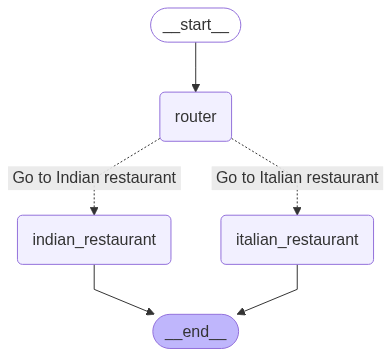

In [19]:
from IPython.display import Image, display
display(Image(chain.get_graph().draw_mermaid_png()))

#### Orchestrator-Worker
Orchestrator and Worker workflow is useful when you want to dynamically assign tasks to different workers based on the current state of the workflow. The orchestrator manages the overall process, while workers handle specific tasks.

In [20]:
from pydantic import BaseModel
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage
import operator
from langgraph.types import Send

# Define the structured output for model
class DishDetails(BaseModel):
    dish_name: Annotated[str, Field(description="The name of the dish")]
    ingredient_details: Annotated[str, Field(description="Details about the ingredients")]
    allergen_details: Annotated[str, Field(description="Details about the allergens")]

llm_with_structured_output = llm.with_structured_output(DishDetails)

# Main state
class State(TypedDict):
    cuisine: str
    dish_name: str
    ingredients: str
    allergens: str
    completed_sections: Annotated[list, operator.add] # Worker will output as a list[str] and operator.add will add them
    final_report: str


def orchestrator(state: State):
    """
    Select a dish from the given state and return its details which are ingredients and allergens.
    """
    details = llm_with_structured_output.invoke(f"from mentioned data, give me any dish name from {state['cuisine']} cuisine from any random but relevant restaurant. Also give me the ingredients and allergens for the dish No any other text. data: {data}")
    return {"dish_name": details.dish_name, "ingredients": details.ingredient_details, "allergens": details.allergen_details}

def dish_history(state: State):
    """
    Retrieve the history of a specific dish based on the sub-state information.
    """
    resp = llm.invoke([
        SystemMessage(content=f"Write 30 words Summary of the dish history for user provided dish details as below. Just describe the origin of the dish and its cultural significance"),
        HumanMessage(content=f"Dish Details: {state['dish_name']}")
    ])
    # Implement logic to retrieve dish history based on dish_details and content
    return {"completed_sections": [resp.content]}

def ingredient_details(state: State):
    """
    Describe the ingredient details 
    """
    resp = llm.invoke([
        SystemMessage(content=f"Write 30 words Summary of the ingredient details for user provided ingredient as below. Summary only includes ingredient name, where it can be found, and any interesting facts."),
        HumanMessage(content=f"Ingredient Details: {state['ingredient_details']}")
    ])
    # Implement logic to retrieve ingredient history based on ingredient_details and content
    return {"completed_sections": [resp.content]}

def allergen_details(state: State):
    """
    Describe the allergen details
    """
    resp = llm.invoke([
        SystemMessage(content=f"Write 30 words Summary of the allergen details for user provided allergen as below. Summary only includes allergen name, where it can be found, and any interesting facts."),
        HumanMessage(content=f"Allergen Details: {state['allergen_details']}")
    ])
    # Implement logic to retrieve allergen history based on allergen_details and content
    return {"completed_sections": [resp.content]}

def final_report_generator(state: State):
    completed_sections = state["completed_sections"]
    return {"final_report": "\n\n---\n\n".join(completed_sections)}

def assign_data_to_worker(state: State):
    """
    Assign dish details to the relevant worker.
    """
    data = {"dish_name": state["dish_name"], "ingredient_details": state["ingredients"], "allergen_details": state["allergens"]}
    return [Send("dish_history", data), Send("ingredient_details", data), Send("allergen_details", data)]


# Create workflow
workflow = StateGraph(State)

workflow.add_node("orchestrator", orchestrator)
workflow.add_node("dish_history", dish_history)
workflow.add_node("ingredient_details", ingredient_details)
workflow.add_node("allergen_details", allergen_details)
workflow.add_node("final_report_generator", final_report_generator)

workflow.add_edge(START, "orchestrator")
workflow.add_conditional_edges(
    "orchestrator", assign_data_to_worker, ["dish_history", "ingredient_details", "allergen_details"]
)
workflow.add_edge("dish_history", "final_report_generator")
workflow.add_edge("ingredient_details", "final_report_generator")
workflow.add_edge("allergen_details", "final_report_generator")
workflow.add_edge("final_report_generator", END)

chain = workflow.compile()


chain.invoke({"cuisine": "Italian"})  # Initial state


{'cuisine': 'Italian',
 'dish_name': 'Spaghetti Carbonara',
 'ingredients': 'Spaghetti, Eggs, Parmesan, Pancetta, Black Pepper',
 'allergens': 'Eggs, Dairy',
 'completed_sections': ["Originating in Rome, Spaghetti Carbonara's creamy, peppery sauce likely emerged post-WWII, using readily available ingredients like eggs, cheese, and cured pork. It's a beloved Italian comfort food.",
  'Spaghetti, eggs, Parmesan, pancetta, and black pepper create a classic Carbonara. Pancetta, cured pork belly, adds a salty, savory depth.',
  'Eggs and dairy are common allergens. Eggs are found in baked goods, pasta, and mayonnaise. Dairy is in milk, cheese, yogurt, and butter.'],
 'final_report': "Originating in Rome, Spaghetti Carbonara's creamy, peppery sauce likely emerged post-WWII, using readily available ingredients like eggs, cheese, and cured pork. It's a beloved Italian comfort food.\n\n---\n\nSpaghetti, eggs, Parmesan, pancetta, and black pepper create a classic Carbonara. Pancetta, cured pork 

#### Evaluator-Optimiser
The Evaluator-Optimiser workflow is useful for assessing the performance of different components within the system and making adjustments to improve overall efficiency. They provide feedback on the effectiveness of various strategies and help identify areas for improvement.


In [21]:
from pydantic import BaseModel, Field
from typing_extensions import Literal, TypedDict
from typing import Annotated
import operator

# Create LLMs with structured output
class DishDetails(BaseModel):
    name: str = Field(description="Name of the dish")
    ingredients: list[str] = Field(description="List of ingredients in the dish")
    allergens: list[str] = Field(description="List of allergens present in the dish")

llm_with_structured_output_1 = llm.with_structured_output(DishDetails)

class Feedback(BaseModel):
    grade: Literal["allergetic", "non-allergenic", "neutral"] = Field(description="Feedback grade for the dish based on allergen content")
    feedback: str = Field(description="Feedback if the dish can be made allergen-free. If not then suggest another dish.")

llm_with_structured_output_2 = llm.with_structured_output(Feedback)

from langgraph.graph import StateGraph, START, END


# Define main state
class State(TypedDict):
    cuisine: str
    dish_name: str
    ingredients: str
    grade: str
    feedback: Feedback
    history_of_selection: Annotated[list[dict[str, str]], operator.add]  # This will store history of selected dishes

# Create Nodes
def select_dish(state: State) -> str:
    # If feedback is present and grade is allergetic, consider feedback in dish selection
    if state.get("feedback", None) and state["grade"] == "allergetic":
        resp = llm_with_structured_output_1.invoke(f"Select a dish from {state['cuisine']} cuisine. Also take {state['feedback']} feedback in account. Data: {data}.")
        state["history_of_selection"].append({"dish_name": resp.name, "ingredients": resp.ingredients, "feedback": state["feedback"]})
    else:
        # If no feedback is present, select dish without considering feedback
        resp = llm_with_structured_output_1.invoke(f"Select a dish from {state['cuisine']} cuisine from given data: {data}")
    return {"dish_name": resp.name, "ingredients": resp.ingredients}

def evaluate_dish(state: State) -> str:
    # If feedback is present, include it in the evaluation
    resp = llm_with_structured_output_2.invoke(f"Evaluate the dish based on its ingredients: {state['ingredients']}. If the dish contains allergens, classify it as 'allergetic'. If it is free from common allergens, classify it as 'non-allergenic'. If unsure, classify it as 'neutral'. Provide feedback on whether the dish can be made allergen-free. If not, suggest an alternative dish.")
    return {"grade": resp.grade, "feedback": resp.feedback}

# Decision on allergenic dish
def route_allergenic_dish(state: State) -> str:
    if state["grade"] == "allergetic":
        return "Rejected + Feedback"
    return "Accepted"

workflow = StateGraph(State)
workflow.add_node("select_dish", select_dish)
workflow.add_node("evaluate_dish", evaluate_dish)

workflow.add_edge(START, "select_dish")
workflow.add_edge("select_dish", "evaluate_dish")
workflow.add_conditional_edges("evaluate_dish", route_allergenic_dish, {
    "Rejected + Feedback": "select_dish",
    "Accepted": END
})

chain = workflow.compile()
chain.invoke({"cuisine": "Italian"})  # Initial state

{'cuisine': 'Italian',
 'dish_name': 'Tomato Pasta',
 'ingredients': ['gluten-free pasta', 'tomato sauce'],
 'grade': 'non-allergenic',
 'feedback': 'The dish is free from common allergens.',
 'history_of_selection': [{'dish_name': 'Tomato Pasta',
   'ingredients': ['gluten-free pasta', 'tomato sauce'],
   'feedback': 'This dish contains eggs and dairy, which are common allergens. It cannot be made entirely allergen-free. An alternative could be a simple tomato-based pasta dish with gluten-free pasta and no cheese.'}]}